In [1]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

train_df = pd.read_csv('data/train.csv', lineterminator="\n")
val_df = pd.read_csv('data/validation.csv', lineterminator="\n")
test_df = pd.read_csv('data/test.csv', lineterminator="\n")

In [2]:
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

STOPWORDS_EN = set(stopwords.words('english'))
NEGATION_WORDS = {"n't", "not", "no", "never"}
PUNCTUATION = set(string.punctuation)
LEMMATIZER = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from utils.pre_processing import normalize_text

train_df.text = train_df.text.progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize", NEGATION_WORDS, PUNCTUATION, STOPWORDS_EN))
test_df.text = test_df.text.progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize", NEGATION_WORDS, PUNCTUATION, STOPWORDS_EN))

# remove unknown words that do not appear in the train set
train_vocab = set(word for doc in train_df.text for word in doc)
test_df.text = test_df.text.progress_apply(lambda tokens: [token for token in tokens if token in train_vocab])

100%|██████████| 183124/183124 [00:00<00:00, 430565.80it/s]


In [4]:
from utils import stratified_downsample

# Downsample to about 50% of the instances for computational limits
train_df = stratified_downsample(train_df, "sentiment", frac=0.5)
test_df = stratified_downsample(test_df, "sentiment", frac=0.5)

y_train = train_df["sentiment"]
y_test = test_df["sentiment"]

In [5]:
from utils.constants import SENTIMENT_LABELS
from models.naive_bayes import train_naive_bayes, test_naive_bayes

classes = [x.capitalize() for x in SENTIMENT_LABELS]

log_prior, log_likelihood, V = train_naive_bayes(train_df, classes)
predictions = test_naive_bayes(test_df, log_prior, log_likelihood, V, classes)

Testing Naive Bayes: 100%|██████████| 91562/91562 [00:03<00:00, 29098.21it/s]


              precision    recall  f1-score   support

    Negative       0.58      0.54      0.56     22918
     Neutral       0.62      0.58      0.60     33388
    Positive       0.67      0.75      0.71     35256

    accuracy                           0.64     91562
   macro avg       0.63      0.62      0.62     91562
weighted avg       0.63      0.64      0.63     91562



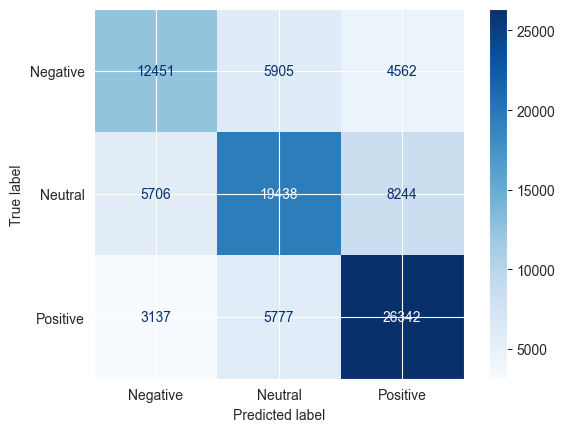

In [7]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# convert true and predicated labels to indices
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
labels = list(label_map.keys())
y_test_indices = [label_map[label] for label in y_test]
y_pred = [label_map[label] for label in predictions]

print(classification_report(y_true=y_test_indices, y_pred=y_pred, target_names=labels))

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=predictions, display_labels=labels, cmap='Blues')